# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

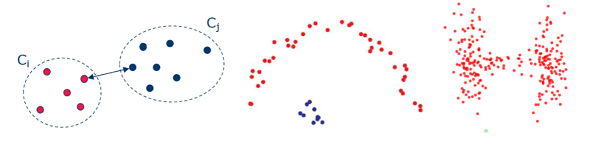

# Review #
Before we start, let's have a quick recap of the lecture.

# Clustering

Clustering a set of data means separating or telling the differences between several data groups. While this sounds a lot like classification, they have different objectives.

1. **Classification** tries to predict the label of unseen data (new data). (*supervised learning*)
2. **Clustering** aims to put all similar data into a group without pre-defined labels. (*unsupervised learning*)

In real life, classification would be used in a decision-making system, like predicting the weather, detecting defects in the manufactory, etc. By comparison, clustering would probably be used in analyzing cases. For example, given the collected sales data and some simple family backgrounds of the customers, we can analyze the data and see what types of customers there are (by looking at how they can be grouped).

Therefore, clustering and classification mean very different things. Although, in some cases, they can be used interchangeably. E.g., knowing how to classify the data is the same as knowing how to cluster it by grouping the data with the same predicted class together; knowing how to cluster the data is basically the same as knowing how to classify it by simply assigning class labels to each cluster.

# K-Means Clustering

One of the simplest clustering algorithms is k-means clustering.
As an **unsupervised** learning algorithm, k-means clustering does not need any label.
It only requires the desired number of clusters, **k**, to be set in advance.
<!-- K-means clustering is an **unsupervised** learning algorithm, which means it doesn't need any labels. Without labels, the model doesn't even know how many classes there are in total. In fact, that's why the algorithm is called "**K**"-mean, because the algorithm would divide all the data into "**K**" clusters, **agnostic to the exact number of groups** that may exist inside the data. -->


## Algorithm

The most standard k-means clustering algorithm is also called *naive k-means*, which consists of the following steps:

- Choose k random data points as the *centroids* of the clusters.
- Repeat the following steps until the centroids no longer change or change very little (convergence):
  - Assign each data point to its closest centroid in terms of the Euclidean distance. Choose one randomly if there is more than one closest centroids.
  - Update the centroids as the means of all the data points in the respective clusters.


## Convergence

Let $X = \{\mathbf{x}_1, \dots, \mathbf{x}_n\}$ be the set of data points, and $C = \{\mathbf{c}_1, \dots, \mathbf{c}_k\}$ be the cluster centroids.
Moreover, let $A_j(X)$ be the set of data points assigned to the cluster whose centroid is $\mathbf{c}_j$.

The algorithm is **guaranteed** to converge to a **local** minimum of the sum of squared error (SSE):

$$
    \mathrm{SSE}(A, C; X) = \sum_{j=1}^{k}\sum_{\mathbf{x} \in A_j(X)}\mathrm{dist}(\mathbf{x}, \mathbf{c}_j)^2
$$

where $\mathrm{dist}(\cdot, \cdot)$ is the Euclidean distance.
Moreover, SSE **decreases monotonically** until convergence, making it a great metric to check whether the algorithm has (nearly) converged.

Below is a proof of the convergence and the monotonicity of SSE in case you are interested.

### Proof

We use superscript $t$ to denote the number of iterations completed at a certain time.
We show that for any $t > 1$, $\mathrm{SSE}(A^t, C^t; X) \leq \mathrm{SSE}(A^{t-1}, C^{t-1}; X)$ and the equality holds if and only if $C^{t-1} = C^t$.

First, since every data point is assigned to its closest centroid, we have $\mathrm{SSE}(A^t, C^{t-1}; X) \leq \mathrm{SSE}(A^{t-1}, C^{t-1}; X)$, which is obvious.

Next, let $\boldsymbol{\delta}_j = \mathbf{c}_j^{t-1} - \mathbf{c}_j^t$, we have $\mathrm{SSE}(A^t, C^t; X) \leq \mathrm{SSE}(A^t, C^{t-1}; X)$ because

\begin{split}
\mathrm{SSE}(A^t, C^{t-1}; X) - \mathrm{SSE}(A^t, C^t; X)
&= \sum_{j=1}^{k}\sum_{\mathbf{x}^t \in A_j^t(X)}\mathrm{dist}(\mathbf{x}^t, \mathbf{c}_j^t + \boldsymbol{\delta}_j)^2 - \mathrm{dist}(\mathbf{x}^t, \mathbf{c}_j^t)^2 \\
&= \sum_{j=1}^{k}\sum_{\mathbf{x}^t \in A_j^t(X)} -2 \boldsymbol{\delta}_j \cdot (\mathbf{x}^t - \mathbf{c}_j^t) + \lVert\boldsymbol{\delta}_j\rVert^2 \\
&= \sum_{j=1}^{k} n_j\lVert\boldsymbol{\delta}_j\rVert^2 + \sum_{j=1}^{k} 2 n_j \boldsymbol{\delta}_j \cdot \left( \mathbf{c}_j^t - \frac{1}{n_j}\sum_{\mathbf{x}^t \in A_j^t(X)} \mathbf{x}^t  \right)\\
&= \sum_{j=1}^{k} n_j\lVert\boldsymbol{\delta}_j\rVert^2 \geq 0
\end{split}

where $n_j$ is the number of data points in $A_j(X)$. This completes the proof.

## Stopping criterion

As we have seen, convergence of k-means clustering means that the centroids do not change, or equivalently, the SSE does not decrease.
In theory, to get the best results, we should not stop until we reach the final convergence.

In real-world cases, however, we often stop **when the change in the centroids or the SSE is smaller** than some threshold value.
This **saves time while not sacrificing too much performance** as the final convergence may take much longer while yielding very little improvement.

In addition, we can also use the **maximum number of iterations** as a stopping criterion when it is difficult to decide what the threshold value should be.

## Limitations

There are some limitations of k-means clustering. For example,
- It is very sensitive to centroids initialization and outliers.
- It fits poorly on data groups in sophisticated shapes (non-hyper ellipsoids or hypersphere).
- The choices of k could lead to drastically different results.
- It cannot handle categorical feature values.

Now we will take a closer look at these limitations one by one.
We use the `KMeans` class from the sklearn library to demonstrate those limitations.

To start with, we create a synthetic 2D dataset with 4 clusters.

Features (X.shape): (400, 2)


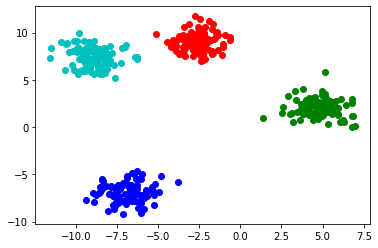

In [1]:
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

def plot_diagram(X, y=None, k=None):
    cycol = cycle('rgbcmk')                             # Create a color cycle iterable object
    if y is not None:                                   # y is the label of each individual points
        if k is None:                                   # k is number of cluster there is
            k = y.max() + 1                             # The total number of clusters is the max label + 1, assuming
                                                        # the class labels are consecutive and start from 0
        for i, c in zip(range(k), cycol):
            plt.scatter(*X[y == i].T, c=c)              # Plot points of class with color c

def plot_points(points, marker='o'):
    plt.scatter(*points, c='w', marker=marker)          # Plot points with color white and specified shape

# Create a dataset with 4 blobs of cluster
X, y = datasets.make_blobs(400, 2, centers=4, random_state=42)
plot_diagram(X, y)
print('Features (X.shape):', X.shape)

### Limitation 1 -  Very sensitive to centroids initialization and outliers

After generating the dataset, we run the k-means algorithm on this dataset to find the clusters.
For the first model, we force it to use random seed **5** in the random initialization and provide the true cluster numbers (4 clusters) for the model. We can see that the algorithm correctly clusters our data points into 4 distinct clusters.

KMeans using random seed 5 to initialize 4 cluster centroids.


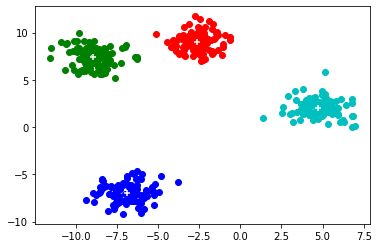

In [2]:
kmeans_seed5 = KMeans(n_clusters=4, random_state=5, init='random', n_init=1)
kmeans_seed5 = kmeans_seed5.fit(X)
print('KMeans using random seed 5 to initialize 4 cluster centroids.')
plot_diagram(X, kmeans_seed5.labels_, 4)
plot_points(kmeans_seed5.cluster_centers_.T, marker='+')

Then, let's try doing the k-means with another random seed used for random initialization, says, random seed **1**. We can see that this results in bad clustering even though the algorithm has converged.

KMeans using random seed 1 to initialize 4 cluster centroids.


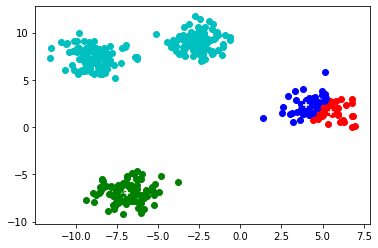

In [3]:
kmeans_seed1 = KMeans(n_clusters=4, random_state=1, init='random', n_init=1)
kmeans_seed1 = kmeans_seed1.fit(X)
print('KMeans using random seed 1 to initialize 4 cluster centroids.')
plot_diagram(X, kmeans_seed1.labels_, 4)
plot_points(kmeans_seed1.cluster_centers_.T, marker='+')

Besides being sensitive to random initialization, k-means is also sensitive to outliers because the mean value (used by the algorithm to calculate the centroids) is easily influenced by extreme values. As shown below, a few outliers make the solution clearly undesirable.

KMeans using random seed 5 to initialize 4 cluster centroids.


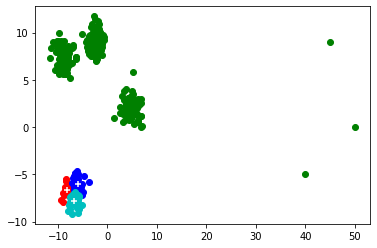

In [4]:
outliers = np.array([(50, 0), (45, 9), (40, -5)])
X_with_outliers = np.vstack([X, outliers])
kmeans_seed5_with_outliers = KMeans(n_clusters=4, random_state=5, init='random', n_init=1)
kmeans_seed5_with_outliers = kmeans_seed5_with_outliers.fit(X_with_outliers)
print('KMeans using random seed 5 to initialize 4 cluster centroids.')
plot_diagram(X_with_outliers, kmeans_seed5_with_outliers.labels_, 4)
plot_points(kmeans_seed5_with_outliers.cluster_centers_.T, marker='+')

To avoid these issues, we should first remove the outliers (if any) from the data, run the algorithm multiple times with different initialization, and then pick the one with the smallest SSE.

In [5]:
kmeans_seed1.inertia_, kmeans_seed5.inertia_  # here in sklearn, inertia_ means SSE

(2816.663979592612, 766.5183043840314)

### Limitation 2 -  Fits poorly on data groups in sophisticated shapes

In general, k-means only performs well on data groups in convex (or near-convex) shapes because the data points are always assigned to its closest centroids. Below, a) are examples of convex shapes, and (b) are examples of non-convex shapes.

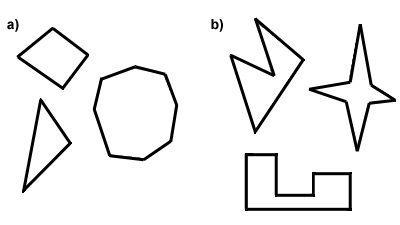

Let’s see an example where k-means cannot generate good clusters in any way.

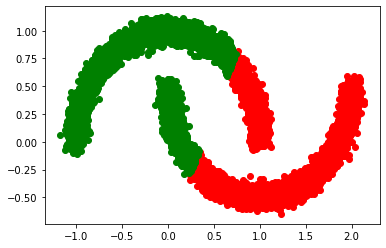

In [6]:
X_moon, y_moon = datasets.make_moons(10000, noise=0.05)
kmeans_moons = KMeans(n_clusters=2)
kmeans_moons = kmeans_moons.fit(X_moon)
plot_diagram(X_moon, kmeans_moons.labels_, 2)
plot_points(kmeans_moons.cluster_centers_.T, marker='+')

For such datasets, we need to use more advanced clustering algorithms. See [this](https://scikit-learn.org/stable/modules/clustering.html) for a comparison of various clustering algorithms.

### Limitation 3 -  The choices of K could lead to drastically different results

For k-means, we need to set the number of clusters beforehand. However, we may not know how many clusters exist in the data distribution in advance. Moreover, sometimes, the number of clusters is exactly what we would like to find out.
If k is not set properly, the algorithm won't perform well.

Here, let’s reuse the previous well-clustered example but with the number of clusters equals to **6 (was 4)**.

KMeans using random seed 5 to initialize 6 cluster centroids.


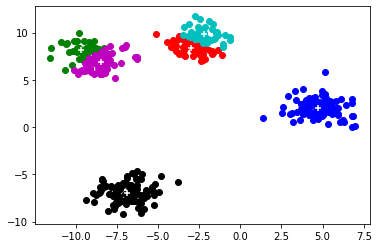

In [7]:
kmeans_seed5_new = KMeans(n_clusters=6, random_state=5, init='random', n_init=1)
kmeans_seed5_new = kmeans_seed5_new.fit(X)
print('KMeans using random seed 5 to initialize 6 cluster centroids.')
plot_diagram(X, kmeans_seed5_new.labels_, 6)
plot_points(kmeans_seed5_new.cluster_centers_.T, marker='+')

 The results is clearly undesirable although the SSE is smaller.

In [8]:
kmeans_seed5.inertia_, kmeans_seed5_new.inertia_  # here in sklearn, inertia_ means SSE

(766.5183043840314, 625.6722019003074)

There are several methods to help us select a good k, e.g., [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) and [Silhouette method](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
The Elbow method is relatively easy to understand, although often less reliable, and it uses SSE to help determine the value of k.

### Limitation 4 -  Cannot handle categorical features

An example of numerical features: **people’s height - 180 cm, 160 cm, 175 cm, etc.** <br>
An example of categorical features: **favorite animal - cat, dog, elephant, etc.**

Problem: categorical features do not have inherent values and thus we cannot compute the means.

Solution: **K-modes** and **K-prototypes**.

#### K-modes
K-modes follows exactly the same procedure as k-means except for two key differences:
1. Instead of calculating the **Euclidean Distance** between each data point and cluster centroids, it treats the **Hamming Distance** as the measurement of distance. Basically, it is the number of features that are different. See reference: https://en.wikipedia.org/wiki/Hamming_distance.
2. Instead of calculating the **mean** value of data points that are assigned to the same cluster as the new centroids, it computes the **mode** value, that is, the most common category of every feature among the assigned data points of a cluster.

Apparently, k-modes is able to handle categorical features, but it loses the ability to handle numerical features.

#### K-prototypes
For data with both numerical and categorical features, as it is often the case in real applications, we can use k-prototypes.
K-prototypes treat the two types of features **separately**:

- for each numerical feature, it computes the **Euclidean distance** and the **mean**;
- for each categorical feature, it computes the **Hamming distance** and the **mode**.

The final distance is a combination of those distances.

Now, we have a model that can handle both categorical and numerical features! There are many other variants of k-means that address its limitations. Next, we will implement another variant of k-means on our own.

In [9]:
### This is the end of the review
### Designed by COMP2211 teaching team